In [80]:
#helper libraries
import numpy as np
from numpy.random import rand
import math
import scipy.optimize
import matplotlib.pyplot as plt

#qiskit functionalities
from qiskit import Aer, execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram

#noise model stuff
from qiskit.providers.aer.noise import NoiseModel, kraus_error, pauli_error
    
#operator info
from qiskit.quantum_info import PauliList, Pauli, Kraus
from qiskit.circuit.library import XGate

#%load_ext autoreload
#%autoreload 2
import PauliExperimentHelperFunctions as pe

## Learn the model

The module `PauliExperimentHelperFunctions` condenses all of the code from the previous journal into a few methods to make it more compact. The code below creates a noise model based on the parameters $\lambda_k$ given in `coeffs`, then measures the fidelities of the Pauli operators in `F` at different circuit depths, performs a fit to get the fidelities, and lastly approximates model coefficients that match the measured fidelities using the least squares method.

In [132]:
n = 1 #Number of qubits
F = PauliList(['I', 'X', 'Y', 'Z']) #list of paulis
T = PauliList(['X', 'Y', 'Z']) #paulis considered in the model
coeffs = [.01, .05, .0085] #model coefficients

#Kraus error channel
noise_model = pe.build_noise_model(F, T, coeffs, n)

backend = Aer.get_backend('qasm_simulator')
gate = XGate() #the gate to use for noise profiling
folds = 40 #number of folds to fit noise
shots = 4096 #number of shots for expectation values

#generate the circuits with increasing numbers of folds
circuits = pe.generate_circuits('X', gate, folds)
#extract expectation values at each circuit depth
xfidelities = pe.fidelity_experiment(circuits, backend, noise_model,shots)

#repeat for <Y>
circuits = pe.generate_circuits('Y', gate, folds)
yfidelities = pe.fidelity_experiment(circuits, backend, noise_model,shots)

#repeat for <Z>
circuits = pe.generate_circuits('Z', gate, folds)
zfidelities = pe.fidelity_experiment(circuits, backend, noise_model,shots)

measured_fidelities = pe.learn_fidelities(xfidelities, yfidelities, zfidelities)
#get the coefficients from the fit
measured_coeffs = pe.learn_model_coefficients(measured_fidelities, F, T)

def unzip(zippedlist):
    return [a for (x,a) in zippedlist]

def manhattannorm(a, b):
    return np.sum(np.abs(np.subtract(a,b)))

print("Manhattan distance between measured/ideal fidelity vectors: ", "%.5f" %manhattannorm(unzip(pe.get_ideal_fidelities(F, T, coeffs)), unzip(measured_fidelities)))
print("Manhattan distance between measured/ideal model coefficients: ", "%.5f" %manhattannorm(unzip(measured_coeffs), coeffs))

Manhattan distance between measured/ideal fidelity vectors:  0.00688
Manhattan distance between measured/ideal model coefficients:  0.00310


## Canonical Noise Scaling

Canonical noise scaling involves separating the distribution into the negative and positive volumes by the sign of the coefficients. Given a QPD representation of a unitary $\mathcal{U}$ in terms of noisy gates $\mathcal{O}_\alpha\in \mathcal{I}$,
$$
\mathcal{U} = \sum_{\alpha} \eta_\alpha \mathcal{O}_\alpha
$$
the indices $\alpha$ corresponding to negative and positive coefficients can be separated into two sets:
$$
D^{\pm} = \{\alpha \ | \ \eta_\alpha \gtrless 0\}
$$
Then the gates corresponding to each set can be used to construct a TPCP operator:
$$
\Phi^{\pm} = \frac{1}{\gamma^{\pm}}\sum_{\alpha \in D^{\pm}}|\eta_\alpha| \mathcal{O}_\alpha
$$
Where the overhead is selected so that the operator is trace-preserving:
$$
\gamma^{\pm} = \sum_{\alpha \in D^{\pm}}|\eta_\alpha|
$$
Then $\mathcal{U}$ can be written in terms of these channels:
$$
\mathcal{U} = \gamma^+ \Phi^+ - \gamma^- \Phi^-
$$
A noisy gate $\mathcal{U}^\lambda$ can be parameterized as
$$
\mathcal{U}^\lambda = (\gamma^+-\lambda \gamma^-)\Phi^+-(1-\lambda)\gamma^-\Phi^-
$$
This has the convenient property that at $\lambda = 0$ it reduces to the ideal QPD, at $\lambda = 1$ it reduces to $\Phi^+$ representing around hardware noise level, and at $\lambda = \frac{\gamma^+}{\gamma^-}$ it reduces to $\Phi^-$, representing the greatest level of noise.

## Separating negative and positive volumes

In the text, it is shown that taking $\mathcal{L} \to -\mathcal{L}$ leads to the inverse of the channel fidelities $f_a \to \frac{1}{f_a}$. Using the Walsh-Hadamard transform, these fidelities can be used to define a Pauli channel:
$$
\Lambda^{-1}(\rho) = \sum_{i} c_i P_i \rho P_i
$$
where the coefficient $c_i$ can be found with
$$
c_i = \sum_{j \in \mathcal{F}}(-1)^{\langle i, j \rangle_{sp}}\frac{1}{f_a}
$$
This leads to an unphysical inverse map where some of the eigenvalues are negative, which can be implemented as a QPD. I am not sure if the sampling remains efficient because the number of operators to sample now scales as $4^n$. I think this might make this method intractible, unless there is a more efficient way to get the positive and negative volumes.

In [86]:
#Invert the fidelities and transform to inverse process matrix
chi = []
for b in range(len(F)):
    chi.append(pe.WHtransform(b, np.divide(1, unzip(measured_fidelities)), F))
print("Chi matrix diagonal: ", chi)

Chi matrix diagonal:  [1.072977523076903, -0.010042797461849273, -0.054043160259660106, -0.00889156535539376]


Separate the volume into negative and positive, then form the TPCP channels by computing overheads and converting into QPD

In [87]:
Dplus = [i for (i, c) in enumerate(chi) if c > 0]
Dminus = [i for (i, c) in enumerate(chi) if c < 0]

gammaplus = np.sum([chi[i] for i in Dplus])
gammaminus = np.multiply(-1, np.sum([chi[i] for i in Dminus]))

#Transform the probabilities in chi into valid probability distribution
for alpha in Dplus:
    chi[alpha] /= gammaplus
for alpha in Dminus:
    chi[alpha] /= -gammaminus

print("Positive channel overhead: ", "%.3f" % gammaplus)
print("Negative channel overhead: ", "%.3f" % gammaminus)

Positive channel overhead:  1.073
Negative channel overhead:  0.073


In [88]:
samples = 4096 #number of samples from the distribution

Create circuit with a single layer of a one-qubit gate to measure the expectation value

In [89]:
ideal_circuit = QuantumCircuit(1,1)
ideal_circuit.x(0)

full_circuit = ideal_circuit.copy()#for displaying purposes
full_circuit.measure(0,0)

#get unmitigated value by taking the same number of samples of a noisy circuit
backend = Aer.get_backend("qasm_simulator")
job = execute(full_circuit, backend, noise_model = noise_model, basis_gates = noise_model.basis_gates, shots = samples)
unmitigated_value = pe.expectation(job.result().get_counts())

ideal_circuit.barrier()
full_circuit.draw()

┌───┐┌─┐
  q: ┤ X ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0

## Procedure for Canonical Noise Scaling
Create a distribution of circuits in `circuits` such that the map
$$
(\gamma^+-\lambda \gamma^-)\Phi^+-(1-\lambda)\gamma^-\Phi^-
$$
is implemented. First, when $\lambda < 1$, the total overhead can be defined as
$$
\gamma_{tot} = \gamma - 2\lambda \gamma^-
$$
Where $\gamma = \gamma^++\gamma^-$ is the normal overhead. The protocol is the following:
1. Sample $\Phi^+$ with probability $\frac{\gamma^+-\lambda \gamma^-}{\gamma-2\lambda\gamma^-}$ and sample $\Phi^-$ otherwise
2. If from $\Phi^+$, then
    1. Sample from $\mathcal F$ (the set of Paulis) according to the subset $\chi_{D^+}$, which has been converted to a distribution
    2. Scale the result of running the circuit by $\gamma-2\lambda \gamma^-$
    3. Add to total result
3. If from $\Phi^{-}$ then
    1. Sample from $\mathcal F$ according to the subset $\chi_{D^-}$, which has been converted to a distribution
    2. Scale the result of the circuit by $-(\gamma-2\lambda \gamma^-)$,
    3. Add to the total result
4. Find the value of the estimator by dividing the total by the number of samples

If $\lambda_{max} > \lambda > 1$, then the overhead is zero and the operation is already a valid distribution.

In [90]:
#Sample from a distribution
def sample(dist):
    i = rand()
    intervals = np.cumsum(dist)
    return min(j for j,c in enumerate(intervals) if c > i)

def simulate_error_mitigation(starting_circuit, samples, 
                              Dplus, Dminus, chi, gammaplus, gammaminus, lmbda,
                              backend, noise_model):
    #check if lambda is within the allowed range
    if(lmbda > gammaplus/gammaminus):
        print("Lambda is above maximum noise")
        return
    
    if(lmbda < 1):
        gamma_tot = gammaplus+gammaminus-2*lmbda*gammaminus #factor if lambda < 1
    else:
        gamma_tot = 1 #factor if lambda > 1
        
    pplus = (gammaplus - lmbda*gammaminus)/gamma_tot #probability of choosing Phi^+
        
    circuits = []
    sgns = []
    
    for i in range(samples):
        circuit = ideal_circuit.copy() #start with ideal circuit
        op = F[0] #how do you initialize variables in python?
        
        if rand() < pplus: #sample Phi^+ or Phi^-
            op = F[Dplus[sample([chi[a] for a in Dplus])]] #sample from paulis
            sgns.append(1) #record the sign chosen for later
        else:
            op = F[Dminus[sample([chi[a] for a in Dminus])]] #sample from paulis
            if gamma_tot == 1:
                sgns.append(1)
            else:
                sgns.append(-1) #record sign
            
        circuit.append(op.to_instruction(), [0]) #add op to circuit
        circuit.measure(0,0)
        circuits.append(circuit)
    
    #execute all circuits from the distribution with one shot apiece
    job = execute(circuits, backend, noise_model = noise_model, basis_gates = noise_model.basis_gates, shots = 1)
    counts = job.result().get_counts()
    
    #weight the individual measurements and average according to the procedure
    total = 0
    for (count, sign) in zip(job.result().get_counts(), sgns):
        total += pe.expectation(count)*gamma_tot*sign
        
    return (total / len(sgns), gamma_tot)

## Find estimator for different values of $\lambda$

In [91]:
lmbdas = [0, .2, .4, .6, .8, 1, 1.2]
mitigated_values = []
overheads = []
#Run the procedure for each lambda
for lmbda in lmbdas:
    mitigated_value, overhead = simulate_error_mitigation(ideal_circuit, samples, Dplus, Dminus, chi, gammaplus, gammaminus, lmbda, backend, noise_model)
    mitigated_values.append(mitigated_value)
    overheads.append(overhead) #overhead interpolates linearly between max overhead and 1

Maximum overhead:  1.15


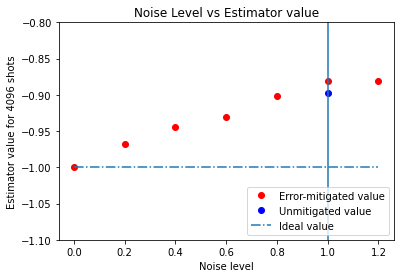

In [92]:
xrange = np.linspace(0, max(lmbdas), 100)
plt.ylim([-1.1, -.80])
mv, = plt.plot(lmbdas, mitigated_values, 'ro')
umv, = plt.plot(1.0, unmitigated_value, 'bo')
iv, = plt.plot(xrange, [-1]*len(xrange), '-.')
plt.xlabel("Noise level")
plt.ylabel("Estimator value for %s shots" %samples)
plt.axvline(1)
plt.title("Noise Level vs Estimator value")
plt.legend([mv, umv, iv], ['Error-mitigated value', 'Unmitigated value', 'Ideal value'], loc="lower right")
print("Maximum overhead: ", "%.2f" % overheads[0])

## Parameter Noise Scaling

I observed that the Sparse Pauli-Lindblad model gives rise to an intuitive definition of scaled noise by taking $\lambda_k \to \lambda \lambda_k$, where $\lambda \in [0,1]$ is the strength of the noise. Since all the terms in $\mathcal{L}$ are mutually commuting,

$$
e^{\lambda \mathcal{L}(\rho)} = e^{\mathcal{L}(\rho)-\mathcal{L}(\rho)}e^{\lambda \mathcal{L}(\rho)} = \Lambda(\rho) e^{-(1-\lambda)\mathcal{L}(\rho)}
$$

Let 
$$
\Lambda_{(\lambda)}(\rho) \equiv e^{-(1-\lambda)\mathcal{L}(\rho)}
$$

be the map that takes the noise to the desired strength. This map can be expanded into product form as before:

$$
\Lambda_{(\lambda)}(\rho) = \frac{1}{2}(e^{2(1-\lambda)\lambda_k}+1)\rho-\frac{1}{2}(e^{2(1-\lambda)\lambda_k}-1)P_k\rho P_k
$$

When $\lambda < 1$, it can be seen that $e^{2(1-\lambda)\lambda_k} > 1$, so the second term is negative. The overhead of the $k^\text{th}$ term is then
$$
\gamma_{(\lambda)}^{(k)} = \frac{1}{2}(e^{2(1-\lambda)\lambda_k}+1)+\frac{1}{2}(e^{2(1-\lambda)\lambda_k}-1) = e^{2(1-\lambda)\lambda_k}
$$
And the total overhead is
$$
\gamma_{(\lambda)} = \prod_{k \in \mathcal{T}} \gamma_{(\lambda)}^{(k)} = e^{2(1-\lambda)\sum_k\lambda_k}
$$
The term $\phi_k \equiv \frac{1}{2}(1+e^{-2(1-\lambda)\lambda_k})$ can be used to write the product in quasiprobability form:
$$
\Lambda_{(\lambda)}(\rho) = \gamma_{(\lambda)}\prod_{k\in\mathcal{T}} \phi_k \rho-(1-\phi_k)P_k\rho P_k
$$
The sampling can be accomplished as with the inverse map. In the case where $\lambda > 1$, then the second term in the sum is positive, and the product is already a probability distribution with overhead $1$.

There is no natural limit to the scaling of this noise above hardware level. The largest error probability is
$$
\prod_k \frac{1}{2}(1-e^{-2(\lambda-1)\lambda_k}) < \left(\frac{1-e^{-2(\lambda-1)\lambda_{min}}}{2}\right)^k <1
$$
Since $e^{-2(\lambda-1)\lambda_{min}}\leq 1$ for all $\lambda_{min}$, there is no upper bound on $\lambda$.

In [93]:
def uniform_noise_scaling(lmbda, samples, ideal_circuit, measured_coeffs, backend, noise_model, T):
    circuits = []
    sgns = []

    adjusted_omegas = .5*(np.exp(np.multiply(-2*(1-lmbda), measured_coeffs))+1)
    
    for i in range(samples):
        m = 0 #m keeps track of the sign, with paulis carrying a negative sign
        qc = ideal_circuit.copy()
        op = Pauli('I')
        for (omega, Pk) in zip(adjusted_omegas, T):
            #with probability 1-\omega_k, sample the Pauli gate and compose into operator
            if rand() < 1-omega:
                m+=1
                op = op.compose(Pk) #Wow I spent so long on this silly line
        qc.barrier()
        qc.append(op.to_instruction(),[0])
        qc.barrier()
        qc.measure(0,0)
        circuits.append(qc)
        if lmbda < 1:
            sgns.append((-1)**m)
        else:
            sgns.append(1)
    
    
    job = execute(circuits, backend, noise_model = noise_model, basis_gates = noise_model.basis_gates, shots = 1)
    
    overhead = math.exp(2*(1-lmbda)*np.sum(measured_coeffs))
    
    total = 0
    for (count,sgn) in zip(job.result().get_counts(),sgns):
        total += pe.expectation(count)*sgn*overhead

    mitigated_value = total/samples
    
    return mitigated_value

In [94]:
lmbdas = [0, .2, .4, .6, .8, 1, 1.2]
mitigated_values_scaling = []
#Run the procedure for each lambda
for lmbda in lmbdas:
    mitigated_value = uniform_noise_scaling(lmbda, samples, ideal_circuit, unzip(measured_coeffs), backend, noise_model, T)
    mitigated_values_scaling.append(mitigated_value)

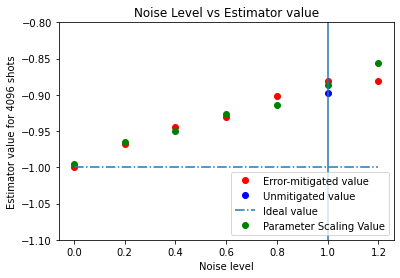

In [95]:
xrange = np.linspace(0, max(lmbdas), 100)
plt.ylim([-1.1, -.80])
mv, = plt.plot(lmbdas, mitigated_values, 'ro')
mvs, = plt.plot(lmbdas, mitigated_values_scaling, 'go')
umv, = plt.plot(1.0, unmitigated_value, 'bo')
iv, = plt.plot(xrange, [-1]*len(xrange), '-.')
plt.xlabel("Noise level")
plt.ylabel("Estimator value for %s shots" %samples)
plt.axvline(1)
plt.title("Noise Level vs Estimator value")
plt.legend([mv, umv, iv, mvs], ['Error-mitigated value', 'Unmitigated value', 'Ideal value', 'Parameter Scaling Value'], loc="lower right")

In [129]:
gamma = math.exp(2*np.sum(unzip(measured_coeffs)))
#overheads_canonical = [gamma*(1-lmbda)+lmbda for lmbda in xrange]
overheads_canonical = [gamma*(1-lmbda)+lmbda for lmbda in xrange]
overheads_scaling = [gamma**(1-lmbda) for lmbda in xrange]

I was surprised to find that these models yield similar overheads. This is true as long as $\gamma \approx 1$. In the Canonical Scaling method, using $\gamma^+-\gamma^- = 1$ and $\gamma^++\gamma^- = \gamma$, the overhead is found to be:
$$
\begin{align*}
\gamma_{can} &= (\gamma^+-\gamma^-)-2\lambda\gamma^-\\
&= \gamma-2\lambda\left(\frac{\gamma-1}{2}\right)\\
&= \gamma(1-\lambda)+\lambda
\end{align*}
$$
Whereas with the noise scaling method, the overhead is
$$
\begin{align*}
\gamma_{param} &= \prod_{k} e^{2(1-\lambda)\lambda_k}\\
&= \left(e^{2\sum_{k}\lambda_k}\right)^{2(1-\lambda)}\\
&= \gamma^{2(1-\lambda)}
\end{align*}
$$
The difference
$$
\gamma_{can}-\gamma_{param} = \gamma(1-\lambda)+\lambda-\gamma^{2(1-\lambda)}
$$
is only positive on the interval $[0,1]$, and is maximized by
$$
\lambda_{max} = 1+\log_{\gamma}\left(\frac{\ln(\gamma)}{\gamma-1}\right)
$$
If the overhead scales weakly exponentially, then $\gamma \to 1$, and $\lambda_{max} \to \frac{1}{2}$, which I found using a computer. Plugging in $\lambda_{max}$,
$$
\gamma_{can} - \gamma_{param} = \frac{1}{2}(\gamma+1)-\sqrt{\gamma} \approx 0
$$
Thus the maximum difference in overhead approaches zero as $\gamma \to 1$. This method does not give the advantage in overhead I was hoping for, but the parameter scaling method is still simpler to sample than the canonical noise scaling method.

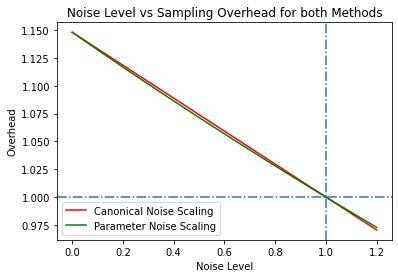

In [130]:
ov, = plt.plot(xrange, overheads_canonical, 'r')
os, = plt.plot(xrange, overheads_scaling, 'g')
plt.axhline(1, linestyle='-.')
plt.axvline(1, linestyle='-.')
plt.xlabel("Noise Level")
plt.ylabel("Overhead")
plt.title("Noise Level vs Sampling Overhead for both Methods")
plt.legend([ov, os], ["Canonical Noise Scaling", "Parameter Noise Scaling"]);